# Bounded Coefficient Encoding Comparison for Simulated Annealing

In [ ]:
import dimod
import neal
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
from collections import Counter
import math
import pandas as pd
from itertools import chain
import time
import networkx as nx
import random 
import itertools

### F1 : Bounded Coefficient Encoding

In [2]:
def bounded_coefficient_encoding(kappa_x, mu_x):
    """
    Bounded Coefficient Encoding; 
    Args: 
        kappa_x: upper bound on integer variable x 
        mu_x: upper bound of coefficients (mu <= kappa)
    Output:
        c_x: integer encoding coefficients
    """

    ### VALIDATION
    if mu_x > kappa_x:
        raise ValueError("mu_x <= kappa_x")
    
    ### SIMPLER CASE:
    if kappa_x < 2**(math.floor(math.log2(mu_x)) + 1):
        
        #return the basic encoding
        log_mu_x = math.floor(math.log2(mu_x))
        
        #encoding vector
        c_x = []
        
        #adding powers of 2: 2^0, 2^1, ..., 2^(floor(log(mu_x)) - 1)
        for i in range(log_mu_x):
            c_x.append(2**i)
        
        #adding the final term: kappa_x - sum(2^(i-1)) for i=1 to floor(log(mu_x))
        sum_powers = sum(2**(i-1) for i in range(1, log_mu_x + 1))
        c_x.append(kappa_x - sum_powers)
        
        return c_x

    #COMPLEX CASE:
    else:
        
        #rho = floor(log(mu_x)) + 1
        rho = math.floor(math.log2(mu_x)) + 1
        
        #nu = kappa_x - sum(2^(i-1)) for i=1 to rho
        nu = kappa_x - sum(2**(i-1) for i in range(1, rho + 1))
        
        #eta = floor(nu / mu_x)
        eta = math.floor(nu / mu_x)
        
        #encoding vector
        c_x = []
        
        # Add coefficients based on the piecewise function
        # For i = 1, ..., rho: c_i = 2^(i-1)
        for i in range(1, rho + 1):
            c_x.append(2**(i-1))
        
        # For i = rho + 1, ..., rho + eta: c_i = mu_x
        for i in range(rho + 1, rho + eta + 1):
            c_x.append(mu_x)
        
        # For i = rho + eta + 1 (if nu - eta*mu_x != 0): c_i = nu - eta*mu_x
        if nu - eta * mu_x != 0:
            c_x.append(nu - eta * mu_x)
        
        return c_x

### F2 : Verifying Encodings

In [5]:
def verify_encoding(c_x, kappa_x, mu_x):
    """
    Verify that the encoding can represent all values from 0 to kappa_x
    and that all coefficients are <= mu_x
    """
    # Check coefficient bounds
    for coeff in c_x:
        if coeff > mu_x:
            return False, f"Coefficient {coeff} exceeds mu_x = {mu_x}"
    
    # Check that we can represent kappa_x
    max_representable = sum(c_x)
    if max_representable < kappa_x:
        return False, f"Cannot represent kappa_x = {kappa_x}, max representable = {max_representable}"
    
    return True, "Encoding is valid"

### TESTING

In [6]:
def test_encodings():
    """Test the algorithm with various inputs"""
    test_cases = [
        (10, 5),    # Simple case
        (100, 20),  # Complex case
        (15, 8),    # Another test
        (7, 3),     # Small values
    ]
    
    for kappa_x, mu_x in test_cases:
        print(f"\nTesting with kappa_x = {kappa_x}, mu_x = {mu_x}")
        try:
            c_x = bounded_coefficient_encoding(kappa_x, mu_x)
            print(f"Encoding coefficients: {c_x}")
            print(f"Number of coefficients: {len(c_x)}")
            print(f"Sum of coefficients: {sum(c_x)}")
            
            is_valid, message = verify_encoding(c_x, kappa_x, mu_x)
            print(f"Verification: {message}")
            
        except Exception as e:
            print(f"Error: {e}")

In [7]:
test_encodings()


Testing with kappa_x = 10, mu_x = 5
Encoding coefficients: [1, 2, 4, 3]
Number of coefficients: 4
Sum of coefficients: 10
Verification: Encoding is valid

Testing with kappa_x = 100, mu_x = 20
Encoding coefficients: [1, 2, 4, 8, 16, 20, 20, 20, 9]
Number of coefficients: 9
Sum of coefficients: 100
Verification: Encoding is valid

Testing with kappa_x = 15, mu_x = 8
Encoding coefficients: [1, 2, 4, 8]
Number of coefficients: 4
Sum of coefficients: 15
Verification: Encoding is valid

Testing with kappa_x = 7, mu_x = 3
Encoding coefficients: [1, 2, 3, 1]
Number of coefficients: 4
Sum of coefficients: 7
Verification: Encoding is valid


### F3 : Finding Upper Bounds (µ)

In [15]:
def find_upper_bounds_coefficients(kappa, q, Q, epsilon_l, epsilon_c, n, max_iterations=1000):
    """
    Algorithm 2: Finding the Upper Bounds on the Coefficients of the Encoding
    """
    # Compute Qκ + q
    Q = np.array(Q)
    kappa = np.array(kappa)
    q = np.array(q)
    Qkappa_plus_q = Q @ kappa + q
    
    # Set ml and mc
    ml = np.min(np.abs(Qkappa_plus_q))
    mc = np.min([np.abs(Q[i,i]) for i in range(n)] + [np.abs(Q[i,j]) for i in range(n) for j in range(i+1,n) if Q[i,j] != 0])
    
    if ml == 0:
        ml = 1e-10  # Avoid division by zero
    if mc == 0:
        mc = 1e-10  # Avoid division by zero
    
    # Initialize μ^xi
    mu_x = []
    for i in range(n):
        val1 = ml / (np.abs(Qkappa_plus_q[i]) * epsilon_l) if Qkappa_plus_q[i] != 0 else float('inf')
        val2 = np.sqrt(mc / (np.abs(Q[i,i]) * epsilon_c)) if Q[i,i] != 0 else float('inf')
        
        mu_xi = min(val1, val2)
        mu_xi = max(1, int(np.floor(mu_xi)))  # Ensure μ >= 1
        mu_x.append(mu_xi)
    
    print(f"Initial mu_x: {mu_x}")
    
    # Main loop with better termination conditions
    iteration = 0
    stuck_count = 0
    last_violation = float('inf')
    
    while iteration < max_iterations:
        # Find the pair (i,j) with maximum violation
        max_violation = 0
        best_i, best_j = -1, -1
        
        for i in range(n):
            for j in range(i+1, n):
                if Q[i,j] != 0:  # Only check non-zero entries
                    violation = mu_x[i] * mu_x[j] - mc / (np.abs(Q[i,j]) * epsilon_c)
                    if violation > max_violation:
                        max_violation = violation
                        best_i, best_j = i, j
        
        # If no violation, we're done
        if max_violation <= 0:
            print(f"Converged after {iteration} iterations")
            break
            
        # Check if we're stuck (violation not decreasing)
        if abs(max_violation - last_violation) < 1e-10:
            stuck_count += 1
        else:
            stuck_count = 0
        last_violation = max_violation
        
        # If stuck for too long, break with warning
        if stuck_count > 10:
            print(f"Warning: Algorithm appears stuck at iteration {iteration}, max_violation = {max_violation}")
            break
        
        # Prevent μ values from going to 0
        if mu_x[best_i] <= 1 and mu_x[best_j] <= 1:
            print(f"Warning: Both mu_x[{best_i}] and mu_x[{best_j}] are at minimum value 1, cannot reduce further")
            break
        
        # Calculate ξi and ξj with bounds checking
        if mu_x[best_i] > 1:
            xi_i = kappa[best_i] / (mu_x[best_i] - 1) + kappa[best_j] / mu_x[best_j]
        else:
            xi_i = float('inf')  # Can't reduce mu_x[best_i]
            
        if mu_x[best_j] > 1:
            xi_j = kappa[best_i] / mu_x[best_i] + kappa[best_j] / (mu_x[best_j] - 1)
        else:
            xi_j = float('inf')  # Can't reduce mu_x[best_j]
        
        # Choose which μ to reduce
        if xi_i < xi_j and mu_x[best_i] > 1:
            mu_x[best_i] -= 1
        elif mu_x[best_j] > 1:
            mu_x[best_j] -= 1
        else:
            print(f"Warning: Cannot reduce either mu_x[{best_i}] or mu_x[{best_j}] further")
            break
            
        iteration += 1
    
    if iteration >= max_iterations:
        print(f"Warning: Algorithm reached maximum iterations ({max_iterations})")
    
    print(f"Final mu_x: {mu_x}")
    return mu_x

### TESTING

In [16]:
def create_test_case():
    """Create a simple test case for the algorithm"""
    n = 3
    kappa = [10, 15, 20]
    q = [5, -3, 8]
    Q = [
        [2, 1, -1],
        [1, 3, 2],
        [-1, 2, 4]
    ]
    epsilon_l = 0.1
    epsilon_c = 0.05
    
    return kappa, q, Q, epsilon_l, epsilon_c, n

def test_bounds():
    """Test the upper bounds algorithm"""
    print("Testing Algorithm 2: Finding Upper Bounds on Coefficients")
    print("=" * 60)
    
    kappa, q, Q, epsilon_l, epsilon_c, n = create_test_case()
    
    print(f"Input parameters:")
    print(f"kappa = {kappa}")
    print(f"q = {q}")
    print(f"Q = {Q}")
    print(f"epsilon_l = {epsilon_l}")
    print(f"epsilon_c = {epsilon_c}")
    print(f"n = {n}")
    print()
    
    try:
        mu_x = find_upper_bounds_coefficients(kappa, q, Q, epsilon_l, epsilon_c, n)
        
        print(f"Results:")
        print(f"Upper bounds mu^(x_i): {mu_x}")
        
        # Display results for each variable
        for i in range(n):
            print(f"mu^(x_{i+1}) = {mu_x[i]}")
        
        print(f"\nTotal coefficient bound budget: {sum(mu_x)}")
        
    except Exception as e:
        print(f"Error during execution: {e}")
        import traceback
        traceback.print_exc()

In [17]:
test_bounds()

Testing Algorithm 2: Finding Upper Bounds on Coefficients
Input parameters:
kappa = [10, 15, 20]
q = [5, -3, 8]
Q = [[2, 1, -1], [1, 3, 2], [-1, 2, 4]]
epsilon_l = 0.1
epsilon_c = 0.05
n = 3

Initial mu_x: [3, 2, 1]
Converged after 0 iterations
Final mu_x: [3, 2, 1]
Results:
Upper bounds mu^(x_i): [3, 2, 1]
mu^(x_1) = 3
mu^(x_2) = 2
mu^(x_3) = 1

Total coefficient bound budget: 6


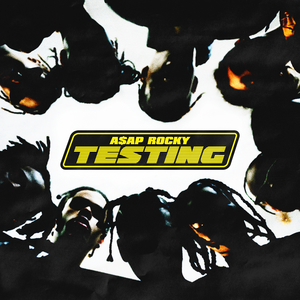

In [24]:
import numpy as np
import random
from scipy.linalg import eigvals
from scipy.optimize import minimize
import itertools
import scipy.linalg as la

### F4 : Generate Convex Instance

In [26]:
def generate_convex_instance(instance_id, n=5, kappa=50, sparsity=0.5):
    """Generate a convex UIQP instance"""
    np.random.seed(instance_id)  # For reproducibility
    
    # Generate sparse Q matrix with entries from U2 = {0, ±1, ±2}
    Q = np.random.choice([-2, -1, 0, 1, 2], size=(n, n))
    
    # Make it symmetric
    Q = (Q + Q.T) / 2
    
    # Apply sparsity (~50%)
    mask = np.random.random((n, n)) < sparsity
    mask = mask & mask.T  # Keep symmetry
    Q = Q * mask
    
    # Make it positive definite by adding λI
    eigvals = np.real(la.eigvals(Q))  # Ensure real eigenvalues
    lambda_min = np.min(eigvals)
    r = np.random.random()  # Random number between 0 and 1
    lambda_add = max(0, -lambda_min) + r
    Q += lambda_add * np.eye(n)
    
    # Generate feasible solution x*
    x_star = np.random.randint(0, kappa+1, n)
    # Set some entries to 0 for sparsity in solution
    zero_mask = np.random.random(n) < 0.3
    x_star[zero_mask] = 0
    
    # Set q = -2Q x*
    q = -2 * Q @ x_star
    
    return Q, q, np.full(n, kappa), x_star

### F5 : Generate Non-Convex Instance

In [27]:
def generate_nonconvex_instance(instance_id, UQ_range, Uq_range, n=5, kappa=50, sparsity=0.5):
    """Generate a non-convex UIQP instance"""
    np.random.seed(instance_id + 100)  # Different seed space
    
    # Generate Q from UQ range
    Q = np.random.choice(range(-UQ_range, UQ_range+1), size=(n, n))
    Q = (Q + Q.T) / 2
    
    # Apply sparsity
    mask = np.random.random((n, n)) < sparsity
    mask = mask & mask.T
    Q = Q * mask
    
    # Generate q from Uq range  
    q = np.random.choice(range(-Uq_range, Uq_range+1), n)
    
    return Q, q, np.full(n, kappa), None

In [28]:
# Generate all 10 instances as described in the paper
instances = []

# 5 convex instances
for i in range(5):
    Q, q, kappa_vec, x_star = generate_convex_instance(i)
    instances.append({
        'name': f'convex-{i+1}',
        'Q': Q, 'q': q, 'kappa': kappa_vec, 'x_star': x_star
    })

# 5 non-convex instances with different U ranges
nonconvex_configs = [
    ('(U2, U200)', 2, 200),
    ('(U5, U200)', 5, 200), 
    ('(U5, U10)', 5, 10),
    ('(U5, U100)', 5, 100),
    ('(U10, U0)', 10, 0)
]

for i, (name, UQ, Uq) in enumerate(nonconvex_configs):
    Q, q, kappa_vec, _ = generate_nonconvex_instance(i, UQ, Uq)
    instances.append({
        'name': name,
        'Q': Q, 'q': q, 'kappa': kappa_vec, 'x_star': None
    })

### F6 : Convert from UIQP to Ising Model

In [29]:
def integer_to_ising(Q, q, encodings, kappa_vec):
    """Convert UIQP to Ising model using given encodings"""
    # Build encoding matrix C
    total_vars = sum(len(enc) for enc in encodings)
    n_orig = len(kappa_vec)
    C = np.zeros((n_orig, total_vars))
    
    col_idx = 0
    for i, encoding in enumerate(encodings):
        for coeff in encoding:
            C[i, col_idx] = coeff
            col_idx += 1
    
    # Transform using equation (16) from paper
    # f(s) = 1/4 * s^T * (C^T Q C - Δ(δ(C^T Q C))) * s + 
    #        1/2 * (C^T Q κ + C^T q)^T * s + constant
    
    CtQC = C.T @ Q @ C
    
    # Quadratic terms (remove diagonal for spins since s_i^2 = 1)
    J_matrix = CtQC / 4
    J = J_matrix - np.diag(np.diag(J_matrix))  # Remove diagonal
    
    # Linear terms (local fields)
    h = (C.T @ Q @ kappa_vec + C.T @ q) / 2
    
    # Add diagonal terms from CtQC to linear terms
    h += np.diag(CtQC) / 4
    
    return J, h

### Process one Single Instance

In [30]:
def process_instance(instance, mu_values):
    """Process one instance with both encodings"""
    Q, q, kappa_vec = instance['Q'], instance['q'], instance['kappa']
    
    # Ensure mu_values are valid
    mu_values = [max(1, int(mu)) for mu in mu_values]  # Ensure all μ >= 1
    
    print(f"Using mu_values: {mu_values}")
    
    # Binary encoding
    binary_encodings = []
    for kappa in kappa_vec:
        width = int(np.ceil(np.log2(kappa + 1)))
        encoding = [2**i for i in range(width)]
        # Adjust last coefficient to not exceed kappa
        total = sum(encoding[:-1])
        if total <= kappa:
            encoding[-1] = kappa - total
        else:
            # Handle edge case where binary encoding can't represent kappa
            encoding = [2**i for i in range(width-1)] + [1]
        binary_encodings.append(encoding)
    
    # Bounded-coefficient encoding (using your Algorithm 1)
    bounded_encodings = []
    for i, kappa in enumerate(kappa_vec):
        try:
            encoding = bounded_coefficient_encoding(kappa, mu_values[i])
            bounded_encodings.append(encoding)
        except Exception as e:
            print(f"Error in bounded encoding for kappa={kappa}, mu={mu_values[i]}: {e}")
            # Fallback to binary encoding
            width = int(np.ceil(np.log2(kappa + 1)))
            encoding = [2**i for i in range(width)]
            total = sum(encoding[:-1])
            if total <= kappa:
                encoding[-1] = kappa - total
            else:
                encoding = [2**i for i in range(width-1)] + [1]
            bounded_encodings.append(encoding)
    
    # Convert to Ising
    try:
        J_binary, h_binary = integer_to_ising(Q, q, binary_encodings, kappa_vec)
        J_bounded, h_bounded = integer_to_ising(Q, q, bounded_encodings, kappa_vec)
    except Exception as e:
        print(f"Error converting to Ising: {e}")
        return None
    
    return {
        'J_binary': J_binary, 'h_binary': h_binary,
        'J_bounded': J_bounded, 'h_bounded': h_bounded
    }

### F7 : Scale Ising Model to Target Range

In [31]:
def scale_ising_model(J, h, target_range=(-1, 1)):
    """Scale Ising model to target range"""
    max_val = max(np.max(np.abs(J)), np.max(np.abs(h)))
    if max_val == 0:
        return J, h
    
    scale_factor = target_range[1] / max_val
    return J * scale_factor, h * scale_factor

### F8 : Solve Ising via Brute Force

In [32]:
def solve_ising_exactly(J, h):
    """Solve Ising model exactly by brute force"""
    n = len(h)
    best_energy = float('inf')
    best_state = None
    
    # Try all 2^n spin configurations
    for i in range(2**n):
        # Convert integer to spin configuration (-1, +1)
        spins = np.array([1 if (i >> j) & 1 else -1 for j in range(n)])
        
        # Calculate energy: E = s^T J s + h^T s
        energy = spins.T @ J @ spins + h.T @ spins
        
        if energy < best_energy:
            best_energy = energy
            best_state = spins.copy()
    
    return best_state, best_energy

### F9 : Define Resilience Metric 

In [33]:
def measure_resilience(J, h, epsilon, n_trials=10):
    """Measure resilience as defined in the paper"""
    # Scale to [-1, 1] range
    J_scaled, h_scaled = scale_ising_model(J, h)
    
    # Find original ground state
    original_ground_state, _ = solve_ising_exactly(J_scaled, h_scaled)
    
    n_same = 0
    
    for trial in range(n_trials):
        # Add Gaussian noise
        noise_J = np.random.normal(0, epsilon, J_scaled.shape)
        noise_h = np.random.normal(0, epsilon, h_scaled.shape)
        
        # Make noise_J symmetric
        noise_J = (noise_J + noise_J.T) / 2
        
        # Perturbed model
        J_noisy = J_scaled + noise_J
        h_noisy = h_scaled + noise_h
        
        # Solve perturbed model
        noisy_ground_state, _ = solve_ising_exactly(J_noisy, h_noisy)
        
        # Check if ground state is the same
        if np.array_equal(original_ground_state, noisy_ground_state):
            n_same += 1
    
    return n_same / n_trials

## Smaller - Scale Testing

### F10 : Ising Solved using SA

In [34]:
def solve_ising_fast(J, h, max_iterations=1000):
    """Fast approximate Ising solver using simulated annealing"""
    n = len(h)
    
    # Random initial state
    state = np.random.choice([-1, 1], n)
    
    def energy(s):
        return s.T @ J @ s + h.T @ s
    
    best_state = state.copy()
    best_energy = energy(state)
    current_energy = best_energy
    
    # Simulated annealing
    for iteration in range(max_iterations):
        # Temperature schedule
        temp = 1.0 * (1 - iteration / max_iterations)
        if temp < 0.01:
            temp = 0.01
            
        # Try flipping a random spin
        i = np.random.randint(n)
        new_state = state.copy()
        new_state[i] *= -1
        
        new_energy = energy(new_state)
        delta_E = new_energy - current_energy
        
        # Accept or reject
        if delta_E < 0 or np.random.random() < np.exp(-delta_E / temp):
            state = new_state
            current_energy = new_energy
            
            if current_energy < best_energy:
                best_state = state.copy()
                best_energy = current_energy
    
    return best_state, best_energy

### F11 : Faster Measurement for Resilience

In [35]:
def measure_resilience_fast(J, h, epsilon, n_trials=10):
    """Fast resilience measurement"""
    # Scale to [-1, 1] range
    J_scaled, h_scaled = scale_ising_model(J, h)
    
    # Find original ground state (approximately)
    original_ground_state, _ = solve_ising_fast(J_scaled, h_scaled)
    
    n_same = 0
    
    for trial in range(n_trials):
        # Add noise
        noise_J = np.random.normal(0, epsilon, J_scaled.shape)
        noise_h = np.random.normal(0, epsilon, h_scaled.shape)
        noise_J = (noise_J + noise_J.T) / 2  # Keep symmetric
        
        # Solve noisy problem
        noisy_ground_state, _ = solve_ising_fast(J_scaled + noise_J, h_scaled + noise_h)
        
        # Check if states are the same
        if np.array_equal(original_ground_state, noisy_ground_state):
            n_same += 1
    
    return n_same / n_trials

### TESTING

In [36]:
def generate_small_test_instances():
    """Generate smaller test instances for quick validation"""
    instances = []
    
    # Much smaller instances: n=3, kappa=10
    for i in range(3):
        np.random.seed(i)
        Q = np.random.choice([-1, 0, 1], size=(3, 3))
        Q = (Q + Q.T) / 2
        q = np.random.choice([-5, -1, 0, 1, 5], 3)
        kappa_vec = np.array([10, 10, 10])
        
        instances.append({
            'name': f'small-{i+1}',
            'Q': Q, 'q': q, 'kappa': kappa_vec
        })
    
    return instances

# Test on small instances first
small_instances = generate_small_test_instances()

def quick_test():
    """Quick test with small instances and fewer epsilon values"""
    
    # Test with just a few epsilon values
    epsilon_values = [0.001, 0.005, 0.01]
    
    for instance in small_instances[:2]:  # Just test 2 instances
        print(f"\nTesting {instance['name']}...")
        
        # Use simple mu values
        mu_values = [5, 5, 5]  # Fixed values for quick test
        
        ising_models = process_instance(instance, mu_values)
        if ising_models is None:
            continue
            
        print(f"Binary Ising size: {ising_models['J_binary'].shape}")
        print(f"Bounded Ising size: {ising_models['J_bounded'].shape}")
        
        # Test just one epsilon value
        eps = 0.005
        res_bin = measure_resilience_fast(ising_models['J_binary'], 
                                        ising_models['h_binary'], eps)
        res_bound = measure_resilience_fast(ising_models['J_bounded'],
                                          ising_models['h_bounded'], eps)
        
        print(f"Binary resilience: {res_bin:.3f}")
        print(f"Bounded resilience: {res_bound:.3f}")

# Run quick test
quick_test()


Testing small-1...
Using mu_values: [5, 5, 5]
Binary Ising size: (12, 12)
Bounded Ising size: (12, 12)
Binary resilience: 1.000
Bounded resilience: 1.000

Testing small-2...
Using mu_values: [5, 5, 5]
Binary Ising size: (12, 12)
Bounded Ising size: (12, 12)
Binary resilience: 1.000
Bounded resilience: 1.000


### F12 : Debug Functions

In [37]:
def debug_encodings(instance, mu_values):
    """Debug what the actual encodings look like"""
    kappa_vec = instance['kappa']
    
    print(f"\nDEBUG: Instance {instance['name']}")
    print(f"Kappa values: {kappa_vec}")
    print(f"Mu values: {mu_values}")
    
    # Binary encoding
    binary_encodings = []
    for i, kappa in enumerate(kappa_vec):
        width = int(np.ceil(np.log2(kappa + 1)))
        encoding = [2**j for j in range(width)]
        # Adjust last coefficient
        total = sum(encoding[:-1])
        if total <= kappa:
            encoding[-1] = kappa - total
        else:
            encoding = [2**j for j in range(width-1)] + [1]
        binary_encodings.append(encoding)
        print(f"  Binary encoding for x_{i} (κ={kappa}): {encoding}")
    
    # Bounded-coefficient encoding  
    bounded_encodings = []
    for i, kappa in enumerate(kappa_vec):
        encoding = bounded_coefficient_encoding(kappa, mu_values[i])
        bounded_encodings.append(encoding)
        print(f"  Bounded encoding for x_{i} (κ={kappa}, μ={mu_values[i]}): {encoding}")
    
    # Check if they're the same
    for i in range(len(kappa_vec)):
        if binary_encodings[i] == bounded_encodings[i]:
            print(f"  ⚠️  WARNING: Encodings for x_{i} are IDENTICAL!")
        else:
            print(f"  ✓ Encodings for x_{i} are different")
    
    return binary_encodings, bounded_encodings

# Test this
instance = small_instances[0]
mu_values = [3, 3, 3]  # Use small mu values to force difference
binary_enc, bounded_enc = debug_encodings(instance, mu_values)


DEBUG: Instance small-1
Kappa values: [10 10 10]
Mu values: [3, 3, 3]
  Binary encoding for x_0 (κ=10): [1, 2, 4, np.int64(3)]
  Binary encoding for x_1 (κ=10): [1, 2, 4, np.int64(3)]
  Binary encoding for x_2 (κ=10): [1, 2, 4, np.int64(3)]
  Bounded encoding for x_0 (κ=10, μ=3): [1, 2, 3, 3, np.int64(1)]
  Bounded encoding for x_1 (κ=10, μ=3): [1, 2, 3, 3, np.int64(1)]
  Bounded encoding for x_2 (κ=10, μ=3): [1, 2, 3, 3, np.int64(1)]
  ✓ Encodings for x_0 are different
  ✓ Encodings for x_1 are different
  ✓ Encodings for x_2 are different


In [38]:
def debug_ising_conversion(Q, q, binary_encodings, bounded_encodings, kappa_vec):
    """Debug the Ising model conversion"""
    
    J_bin, h_bin = integer_to_ising(Q, q, binary_encodings, kappa_vec)
    J_bound, h_bound = integer_to_ising(Q, q, bounded_encodings, kappa_vec)
    
    print(f"\nISING MODEL COMPARISON:")
    print(f"Binary J matrix shape: {J_bin.shape}")
    print(f"Bounded J matrix shape: {J_bound.shape}")
    
    print(f"Binary h vector: {h_bin}")
    print(f"Bounded h vector: {h_bound}")
    
    print(f"Binary J max coefficient: {np.max(np.abs(J_bin)):.3f}")
    print(f"Bounded J max coefficient: {np.max(np.abs(J_bound)):.3f}")
    
    print(f"Binary h max coefficient: {np.max(np.abs(h_bin)):.3f}")
    print(f"Bounded h max coefficient: {np.max(np.abs(h_bound)):.3f}")
    
    # Check coefficient ranges
    binary_coeffs = np.concatenate([J_bin.flatten(), h_bin.flatten()])
    bounded_coeffs = np.concatenate([J_bound.flatten(), h_bound.flatten()])
    
    binary_coeffs = binary_coeffs[binary_coeffs != 0]  # Remove zeros
    bounded_coeffs = bounded_coeffs[bounded_coeffs != 0]
    
    print(f"Binary coefficient range: [{np.min(np.abs(binary_coeffs)):.3f}, {np.max(np.abs(binary_coeffs)):.3f}]")
    print(f"Bounded coefficient range: [{np.min(np.abs(bounded_coeffs)):.3f}, {np.max(np.abs(bounded_coeffs)):.3f}]")
    
    # This is key: check the ratio of max to min coefficients
    binary_ratio = np.max(np.abs(binary_coeffs)) / np.max(np.abs(binary_coeffs))
    bounded_ratio = np.max(np.abs(bounded_coeffs)) / np.min(np.abs(bounded_coeffs))
    
    print(f"Binary coefficient ratio (max/min): {binary_ratio:.3f}")
    print(f"Bounded coefficient ratio (max/min): {bounded_ratio:.3f}")
    
    return J_bin, h_bin, J_bound, h_bound

# Test this
Q, q, kappa_vec = instance['Q'], instance['q'], instance['kappa']
debug_ising_conversion(Q, q, binary_enc, bounded_enc, kappa_vec)


ISING MODEL COMPARISON:
Binary J matrix shape: (12, 12)
Bounded J matrix shape: (15, 15)
Binary h vector: [-12.75 -26.   -54.   -39.75   7.5   15.    30.    22.5   -5.25 -11.
 -24.   -17.25]
Bounded h vector: [-12.75 -26.   -39.75 -39.75 -12.75   7.5   15.    22.5   22.5    7.5
  -5.25 -11.   -17.25 -17.25  -5.25]
Binary J max coefficient: 4.000
Bounded J max coefficient: 2.250
Binary h max coefficient: 54.000
Bounded h max coefficient: 39.750
Binary coefficient range: [0.250, 54.000]
Bounded coefficient range: [0.250, 39.750]
Binary coefficient ratio (max/min): 1.000
Bounded coefficient ratio (max/min): 159.000


(array([[ 0.  , -0.5 , -1.  , -0.75,  0.  ,  0.  ,  0.  ,  0.  , -0.25,
         -0.5 , -1.  , -0.75],
        [-0.5 ,  0.  , -2.  , -1.5 ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,
         -1.  , -2.  , -1.5 ],
        [-1.  , -2.  ,  0.  , -3.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  ,
         -2.  , -4.  , -3.  ],
        [-0.75, -1.5 , -3.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.75,
         -1.5 , -3.  , -2.25],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25,
          0.5 ,  1.  ,  0.75],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,
          1.  ,  2.  ,  1.5 ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
          2.  ,  4.  ,  3.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.75,
          1.5 ,  3.  ,  2.25],
        [-0.25, -0.5 , -1.  , -0.75,  0.25,  0.5 ,  1.  ,  0.75,  0.  ,
         -0.5 , -1.  , -0.75],
        [-0.5 , -1.  , -2.  , -1.5 ,  0.5 ,  1.  ,  2.  ,  1.5 , -0.5 ,
 

In [39]:
def test_paper_examples():
    """Test the exact examples from the paper"""
    
    print("TESTING PAPER EXAMPLES:")
    
    # Example 1: κ = 12, μ = 8
    kappa1, mu1 = 12, 8
    binary1 = [1, 2, 4, 8]  # Standard binary: sum = 15 > 12, so adjust
    binary1 = [1, 2, 4, 5]  # Adjusted: sum = 12
    bounded1 = [1, 2, 4, 5]  # From paper
    
    print(f"Example 1 (κ={kappa1}, μ={mu1}):")
    print(f"  Binary (adjusted): {binary1}")
    print(f"  Bounded (paper): {bounded1}")
    print(f"  Your bounded: {bounded_coefficient_encoding(kappa1, mu1)}")
    
    # Example 2: κ = 20, μ = 6  
    kappa2, mu2 = 20, 6
    binary2 = [1, 2, 4, 8, 5]  # 1+2+4+8+5 = 20
    bounded2 = [1, 2, 4, 6, 6, 1]  # From paper: 1+2+4+6+6+1 = 20
    
    print(f"Example 2 (κ={kappa2}, μ={mu2}):")
    print(f"  Binary: {binary2}")
    print(f"  Bounded (paper): {bounded2}")
    print(f"  Your bounded: {bounded_coefficient_encoding(kappa2, mu2)}")
    
    # The key difference: coefficient ranges
    print(f"\nCoefficient Analysis:")
    print(f"  Binary max coefficient: {max(binary2)}")
    print(f"  Bounded max coefficient: {max(bounded2)}")
    print(f"  Binary range: {max(binary2) - min(binary2)}")
    print(f"  Bounded range: {max(bounded2) - min(bounded2)}")

test_paper_examples()

TESTING PAPER EXAMPLES:
Example 1 (κ=12, μ=8):
  Binary (adjusted): [1, 2, 4, 5]
  Bounded (paper): [1, 2, 4, 5]
  Your bounded: [1, 2, 4, 5]
Example 2 (κ=20, μ=6):
  Binary: [1, 2, 4, 8, 5]
  Bounded (paper): [1, 2, 4, 6, 6, 1]
  Your bounded: [1, 2, 4, 6, 6, 1]

Coefficient Analysis:
  Binary max coefficient: 8
  Bounded max coefficient: 6
  Binary range: 7
  Bounded range: 5


In [40]:
def create_test_with_clear_difference():
    """Create a test case where binary and bounded should clearly differ"""
    
    # Use a case where binary encoding has very large coefficients
    kappa = 50  # Large upper bound
    mu = 4      # Small mu to force difference
    
    print(f"\nFORCING CLEAR DIFFERENCE (κ={kappa}, μ={mu}):")
    
    # Binary encoding for κ=50
    width = int(np.ceil(np.log2(kappa + 1)))  # Should be 6
    binary = [2**i for i in range(width)]
    binary[-1] = kappa - sum(binary[:-1])  # Adjust last
    
    # Bounded encoding  
    bounded = bounded_coefficient_encoding(kappa, mu)
    
    print(f"  Binary: {binary}")
    print(f"  Bounded: {bounded}")
    print(f"  Binary max coeff: {max(binary)}")
    print(f"  Bounded max coeff: {max(bounded)}")
    print(f"  Difference: {max(binary) - max(bounded)}")
    
    # Create simple Ising models
    # Just test single variable case
    Q = np.array([[1]])  # Simple quadratic term
    q = np.array([1])    # Simple linear term
    kappa_vec = np.array([kappa])
    
    J_bin, h_bin = integer_to_ising(Q, q, [binary], kappa_vec)
    J_bound, h_bound = integer_to_ising(Q, q, [bounded], kappa_vec)
    
    print(f"  Binary Ising coefficients: J_max={np.max(np.abs(J_bin)):.3f}, h_max={np.max(np.abs(h_bin)):.3f}")
    print(f"  Bounded Ising coefficients: J_max={np.max(np.abs(J_bound)):.3f}, h_max={np.max(np.abs(h_bound)):.3f}")
    
    return J_bin, h_bin, J_bound, h_bound

J_bin, h_bin, J_bound, h_bound = create_test_with_clear_difference()


FORCING CLEAR DIFFERENCE (κ=50, μ=4):
  Binary: [1, 2, 4, 8, 16, 19]
  Bounded: [1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
  Binary max coeff: 19
  Bounded max coeff: 4
  Difference: 15
  Binary Ising coefficients: J_max=76.000, h_max=574.750
  Bounded Ising coefficients: J_max=4.000, h_max=106.000


### Fixing Debug Func.

In [41]:
def debug_ising_conversion_fixed(Q, q, binary_encodings, bounded_encodings, kappa_vec):
    """Debug the Ising model conversion - FIXED VERSION"""
    
    J_bin, h_bin = integer_to_ising(Q, q, binary_encodings, kappa_vec)
    J_bound, h_bound = integer_to_ising(Q, q, bounded_encodings, kappa_vec)
    
    print(f"\nISING MODEL COMPARISON:")
    print(f"Binary J matrix shape: {J_bin.shape}")
    print(f"Bounded J matrix shape: {J_bound.shape}")
    
    # Collect all non-zero coefficients
    binary_coeffs = np.concatenate([J_bin.flatten(), h_bin.flatten()])
    bounded_coeffs = np.concatenate([J_bound.flatten(), h_bound.flatten()])
    
    binary_coeffs = binary_coeffs[binary_coeffs != 0]  # Remove zeros
    bounded_coeffs = bounded_coeffs[bounded_coeffs != 0]
    
    print(f"Binary coefficient range: [{np.min(np.abs(binary_coeffs)):.3f}, {np.max(np.abs(binary_coeffs)):.3f}]")
    print(f"Bounded coefficient range: [{np.min(np.abs(bounded_coeffs)):.3f}, {np.max(np.abs(bounded_coeffs)):.3f}]")
    
    # FIXED: Correct ratio calculation
    binary_ratio = np.max(np.abs(binary_coeffs)) / np.min(np.abs(binary_coeffs))
    bounded_ratio = np.max(np.abs(bounded_coeffs)) / np.min(np.abs(bounded_coeffs))
    
    print(f"Binary coefficient ratio (max/min): {binary_ratio:.1f}")
    print(f"Bounded coefficient ratio (max/min): {bounded_ratio:.1f}")
    
    # This is the key insight from the paper:
    print(f"\n🎯 KEY INSIGHT:")
    print(f"   Binary has {binary_ratio:.1f}x range in coefficients")
    print(f"   Bounded has {bounded_ratio:.1f}x range in coefficients") 
    print(f"   Bounded should be MORE RESILIENT to noise!")
    
    return J_bin, h_bin, J_bound, h_bound

### TESTING

In [42]:
def create_challenging_instance():
    """Create an instance that should clearly show the difference"""
    
    # Create an instance with large coefficient differences
    Q = np.array([[2, 1, 0],
                  [1, 3, 1], 
                  [0, 1, 2]])
    
    q = np.array([10, -15, 8])  # Large linear terms
    kappa_vec = np.array([50, 50, 50])  # Large bounds
    
    return {
        'name': 'challenging',
        'Q': Q, 'q': q, 'kappa': kappa_vec
    }

def test_resilience_properly():
    """Test resilience with a challenging instance and appropriate noise levels"""
    
    instance = create_challenging_instance()
    
    # Use small mu to force large coefficient differences
    mu_values = [3, 3, 3]  
    
    print(f"Testing {instance['name']} with mu={mu_values}")
    
    # Get encodings
    binary_enc, bounded_enc = debug_encodings(instance, mu_values)
    
    # Convert to Ising
    J_bin, h_bin, J_bound, h_bound = debug_ising_conversion_fixed(
        instance['Q'], instance['q'], binary_enc, bounded_enc, instance['kappa']
    )
    
    # Test multiple noise levels
    epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0]  # Much larger noise levels
    
    print(f"\nRESILIENCE TEST:")
    print(f"Epsilon    Binary    Bounded")
    print(f"-------    ------    -------")
    
    for eps in epsilon_values:
        res_bin = measure_resilience_fast(J_bin, h_bin, eps, n_trials=20)
        res_bound = measure_resilience_fast(J_bound, h_bound, eps, n_trials=20)
        
        print(f"{eps:7.1f}    {res_bin:6.3f}    {res_bound:7.3f}")
        
        # Early exit if we see a clear difference
        if abs(res_bin - res_bound) > 0.1:
            print(f"🎉 FOUND DIFFERENCE! Binary: {res_bin:.3f}, Bounded: {res_bound:.3f}")
            break

# Run the proper test
test_resilience_properly()

Testing challenging with mu=[3, 3, 3]

DEBUG: Instance challenging
Kappa values: [50 50 50]
Mu values: [3, 3, 3]
  Binary encoding for x_0 (κ=50): [1, 2, 4, 8, 16, np.int64(19)]
  Binary encoding for x_1 (κ=50): [1, 2, 4, 8, 16, np.int64(19)]
  Binary encoding for x_2 (κ=50): [1, 2, 4, 8, 16, np.int64(19)]
  Bounded encoding for x_0 (κ=50, μ=3): [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, np.int64(2)]
  Bounded encoding for x_1 (κ=50, μ=3): [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, np.int64(2)]
  Bounded encoding for x_2 (κ=50, μ=3): [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, np.int64(2)]
  ✓ Encodings for x_0 are different
  ✓ Encodings for x_1 are different
  ✓ Encodings for x_2 are different

ISING MODEL COMPARISON:
Binary J matrix shape: (18, 18)
Bounded J matrix shape: (54, 54)
Binary coefficient range: [0.250, 2503.250]
Bounded coefficient range: [0.250, 359.250]
Binary coefficient ratio (max/min): 10013.0
Bounded coefficient ratio (max/min): 1437.0

🎯 


📊 RESILIENCE SUMMARY:
Epsilon  Binary   Bounded  Difference Improvement 
--------------------------------------------------
0.001    0.937    0.949    +0.012     +1.3        %
0.005    0.921    1.000    +0.079     +8.6        %
0.010    0.806    0.919    +0.113     +14.0       %
0.020    0.472    0.812    +0.341     +72.2       %
0.050    0.000    0.535    +0.535     +inf        %

🎯 OVERALL AVERAGE:
   Binary: 0.627
   Bounded: 0.843
   Improvement: +34.5%


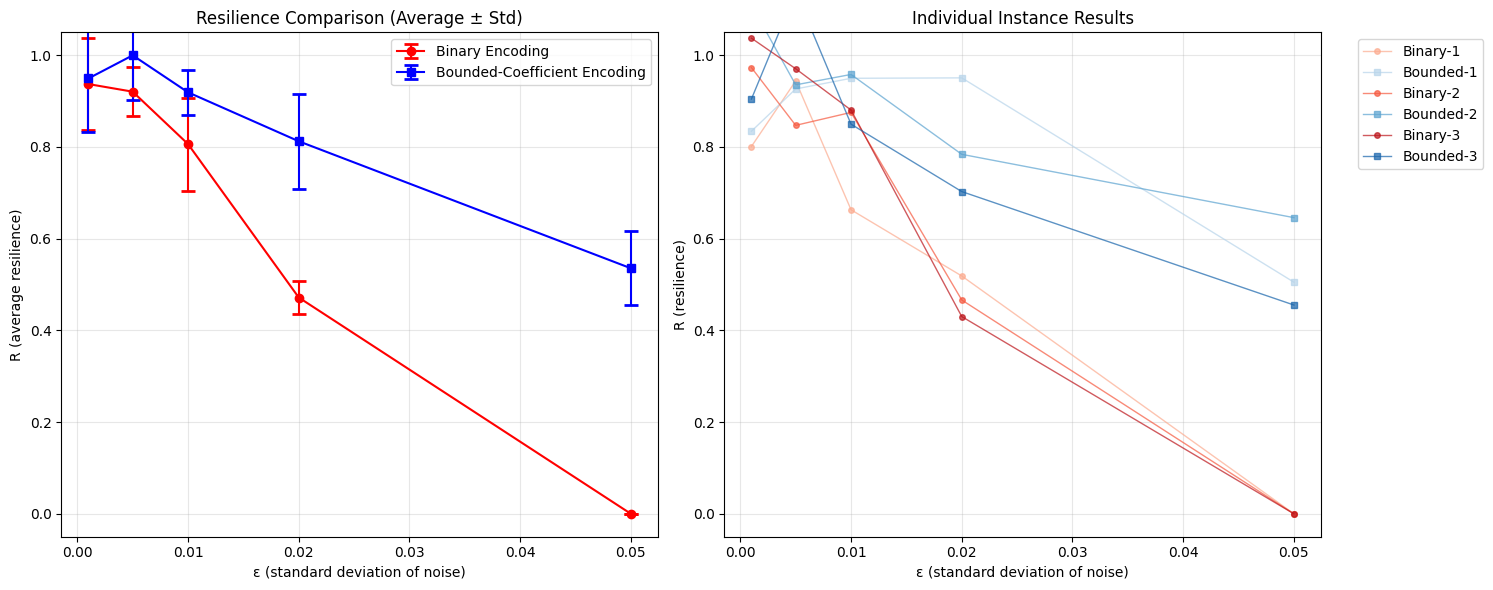

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_improved(results_binary, results_bounded, epsilons, instance_names=None):
    """Enhanced plotting with better visualization and error handling"""
    
    # Convert to numpy arrays for easier handling
    results_binary = np.array(results_binary)
    results_bounded = np.array(results_bounded)
    
    # Handle single instance case
    if results_binary.ndim == 1:
        results_binary = results_binary.reshape(1, -1)
        results_bounded = results_bounded.reshape(1, -1)
    
    # Calculate averages and standard deviations
    avg_binary = np.mean(results_binary, axis=0)
    avg_bounded = np.mean(results_bounded, axis=0)
    std_binary = np.std(results_binary, axis=0)
    std_bounded = np.std(results_bounded, axis=0)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Main comparison plot (left)
    ax1.errorbar(epsilons, avg_binary, yerr=std_binary, 
                fmt='ro-', label='Binary Encoding', capsize=5, capthick=2)
    ax1.errorbar(epsilons, avg_bounded, yerr=std_bounded, 
                fmt='bs-', label='Bounded-Coefficient Encoding', capsize=5, capthick=2)
    
    ax1.set_xlabel('ε (standard deviation of noise)')
    ax1.set_ylabel('R (average resilience)')
    ax1.set_title('Resilience Comparison (Average ± Std)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.05, 1.05)
    
    # Individual instances plot (right)
    colors_bin = plt.cm.Reds(np.linspace(0.3, 0.8, len(results_binary)))
    colors_bound = plt.cm.Blues(np.linspace(0.3, 0.8, len(results_bounded)))
    
    for i, (bin_res, bound_res) in enumerate(zip(results_binary, results_bounded)):
        label_bin = f'Binary-{i+1}' if instance_names is None else f'Binary-{instance_names[i]}'
        label_bound = f'Bounded-{i+1}' if instance_names is None else f'Bounded-{instance_names[i]}'
        
        ax2.plot(epsilons, bin_res, 'o-', color=colors_bin[i], 
                alpha=0.7, linewidth=1, markersize=4, label=label_bin)
        ax2.plot(epsilons, bound_res, 's-', color=colors_bound[i], 
                alpha=0.7, linewidth=1, markersize=4, label=label_bound)
    
    ax2.set_xlabel('ε (standard deviation of noise)')
    ax2.set_ylabel('R (resilience)')
    ax2.set_title('Individual Instance Results')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.05, 1.05)
    
    # Only show legend if not too many instances
    if len(results_binary) <= 5:
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n📊 RESILIENCE SUMMARY:")
    print(f"{'Epsilon':<8} {'Binary':<8} {'Bounded':<8} {'Difference':<10} {'Improvement':<12}")
    print(f"{'-'*50}")
    
    for i, eps in enumerate(epsilons):
        diff = avg_bounded[i] - avg_binary[i]
        if avg_binary[i] > 0:
            improvement = (diff / avg_binary[i]) * 100
        else:
            improvement = float('inf') if diff > 0 else 0
            
        print(f"{eps:<8.3f} {avg_binary[i]:<8.3f} {avg_bounded[i]:<8.3f} {diff:<+10.3f} {improvement:<+12.1f}%")
    
    # Overall summary
    overall_avg_binary = np.mean(avg_binary)
    overall_avg_bounded = np.mean(avg_bounded)
    overall_improvement = ((overall_avg_bounded - overall_avg_binary) / overall_avg_binary) * 100 if overall_avg_binary > 0 else 0
    
    print(f"\n🎯 OVERALL AVERAGE:")
    print(f"   Binary: {overall_avg_binary:.3f}")
    print(f"   Bounded: {overall_avg_bounded:.3f}")
    print(f"   Improvement: {overall_improvement:+.1f}%")
    
    plt.show()
    
    return fig

def plot_single_test(results_binary, results_bounded, epsilons, title="Single Test Results"):
    """Plot results from a single test instance"""
    
    plt.figure(figsize=(10, 6))
    
    # Plot with markers and error bars if available
    plt.plot(epsilons, results_binary, 'ro-', linewidth=2, markersize=8, 
             label='Binary Encoding', markerfacecolor='white', markeredgewidth=2)
    plt.plot(epsilons, results_bounded, 'bs-', linewidth=2, markersize=8,
             label='Bounded-Coefficient Encoding', markerfacecolor='white', markeredgewidth=2)
    
    # Fill area between curves to show difference
    plt.fill_between(epsilons, results_binary, results_bounded, 
                     alpha=0.3, color='green' if np.mean(results_bounded) > np.mean(results_binary) else 'red')
    
    plt.xlabel('ε (standard deviation of noise)', fontsize=12)
    plt.ylabel('R (resilience)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.05, 1.05)
    
    # Add text showing which is better
    better = "Bounded" if np.mean(results_bounded) > np.mean(results_binary) else "Binary"
    avg_diff = np.mean(results_bounded) - np.mean(results_binary)
    plt.text(0.7, 0.9, f'{better} encoding performs better\nAvg difference: {avg_diff:+.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Usage examples:

# For multiple instances:
# plot_results_improved(results_binary, results_bounded, epsilons, 
#                      instance_names=['convex-1', 'convex-2', 'U2-U200'])

# For single test (like your challenging instance):
# eps_vals = [0.1, 0.5, 1.0, 2.0, 5.0]
# binary_res = [0.8, 0.6, 0.4, 0.2, 0.1]  # Example results
# bounded_res = [0.9, 0.8, 0.7, 0.5, 0.3]  # Example results
# plot_single_test(binary_res, bounded_res, eps_vals, "Challenging Instance Test")

# Quick test for your current results:
def quick_plot_test():
    """Quick test with dummy data to verify plotting works"""
    epsilons = [0.001, 0.005, 0.01, 0.02, 0.05]
    
    # Simulate realistic results where bounded performs better
    results_binary = []
    results_bounded = []
    
    for i in range(3):  # 3 instances
        binary = [max(0, 1 - eps*20 + np.random.normal(0, 0.1)) for eps in epsilons]
        bounded = [max(0, 1 - eps*10 + np.random.normal(0, 0.1)) for eps in epsilons]
        results_binary.append(binary)
        results_bounded.append(bounded)
    
    plot_results_improved(results_binary, results_bounded, epsilons)

# Uncomment to test:
quick_plot_test()